![logo](https://github.com/donatellacea/DL_tutorials/blob/main/notebooks/figures/1128-191-max.png?raw=true)

# Explainability for Random Forest Models

In this Notebook we will show you different methods that can be used for interpreting Random Forest models. We will demonstrate you how to compare those methods and choose the appropriate one.

--------

## Getting Started

### Setup Colab environment

If you installed the packages and requirments on your own machine, you can skip this section and start from the import section.
Otherwise you can follow and execute the tutorial on your browser. In order to start working on the notebook, click on the following button, this will open this page in the Colab environment and you will be able to execute the code on your own.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/xai-model-specific/Tutorial_XAI_for_RandomForests.ipynb)

Now that you are visualizing the notebook in Colab, run the next cell to install the packages we will use.
There are few things you should follow in order to properly set the notebook up:

1. Warning: This notebook was not authored by Google. *Click* on 'Run anyway'.
2. When the installation commands are done, there might be "Restart runtime" button at the end of the output. Please, *click* it. 

In [ ]:
# %pip install fgclustering
# %pip install shap

By running the next cell you are going to create a folder in your Google Drive. All the files for this tutorial will be uploaded to this folder. After the first execution you might receive some warning and notification, please follow these instructions:
1. Permit this notebook to access your Google Drive files? *Click* on 'Yes', and select your account.
2. Google Drive for desktop wants to access your Google Account. *Click* on 'Allow'.

At this point, a folder has been created and you can navigate it through the lefthand panel in Colab, you might also have received an email that informs you about the access on your Google Drive. 

In [ ]:
# Create a folder in your Google Drive
# from google.colab import drive                                                                          
# drive.mount('/content/drive')

In [ ]:
# Don't run this cell if you already cloned the repo 
# !git clone https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git

In [ ]:
# %cd XAI-Tutorials/xai-model-specific

### Imports

Let's start with importing all required Python packages.

In [6]:
# Load the required packages

import utils
import joblib
import numpy as np
import pandas as pd


import shap
from fgclustering import FgClustering
from sklearn.metrics import get_scorer
from sklearn.inspection import permutation_importance


import warnings
warnings.filterwarnings('ignore')

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Now, we fix the random seeds to ensure reproducible results, as we work with (pseudo) random numbers.

In [7]:
# assert reproducible random number generation
seed = 1
np.random.seed(seed)

--------

## The Palmer Pinguins Dataset: Data and Model Loading

In this notebook, we will work with the **Palmer penguins dataset**, containing the information on 3 different species of penguins - Adelie, Chinstrap, and Gentoo - which were observed in the Palmer Archipelago near Palmer Station, Antarctica. The dataset consist of a total of 344 penguings, together with their size measurements, clutch observations, and blood isotope ratios. Our goal is to **predict the species** of Palmer penguins and find out the major differences among them.

<center><img src="https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/dataset_penguins.png?raw=true" width="500" /></center>

<font size=1> Source: [Link](https://allisonhorst.github.io/palmerpenguins/)

In the notebook [*Dataset-Penguins.ipynb*](../data_and_models/Dataset-Penguins.ipynb), we explain how to do the exploratory data analysis, preprocess the data and in the notebook [*Model-RandomForest.ipynb*](../data_and_models/Model-RandomForest.ipynb) we train a Random Forest model with the given data. The focus of this notebook lies on the interpretation of the trained model and not on the data pre-processing or model training part. Hence, here we simply load the data and the model that we saved in the previous notebook.

In [8]:
# Load and unpack the data
data_and_model = joblib.load(open('../data_and_models/model_randomforest_penguins.joblib', 'rb'))
X_train = data_and_model[0]
X_test = data_and_model[1]
y_train = data_and_model[2]
y_test = data_and_model[3]
rf = data_and_model[4]

X_train.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year,island_Dream,island_Torgersen,sex_male
0,1.298854,0.829146,0.172736,-0.098112,-0.027431,1.288410,-0.395628,1.030541
1,-0.337272,-1.866725,0.672943,-0.035074,-1.243527,-0.776151,-0.395628,-0.970364
2,0.626225,-0.951146,1.530443,1.351762,-1.243527,-0.776151,-0.395628,1.030541
3,0.989808,-0.747685,1.173151,2.108218,-1.243527,-0.776151,-0.395628,1.030541
4,0.389896,2.202514,-0.470389,0.027964,-1.243527,-0.776151,2.527625,1.030541


Check again how the model performed on train and test set.

In [9]:
# is the model performing reasonably on the training data?
print(f'Model Performance on training data: {round(rf.score(X_train, y_train)*100,2)} % accuracy.')

# is the model performing reasonably on the test data?
print(f'Model Performance on test data: {round(rf.score(X_test, y_test)*100,2)} % accuracy.')

Model Performance on training data: 99.62 % accuracy.
Model Performance on test data: 95.52 % accuracy.


The generalization of our model is very good with 95% test accuracy. However, you should keep in mind that interpreting a low performing model can lead to wrong conclusions.

Below, we plot the correlation between the model features that we should be aware of when using some of the XAI methods.

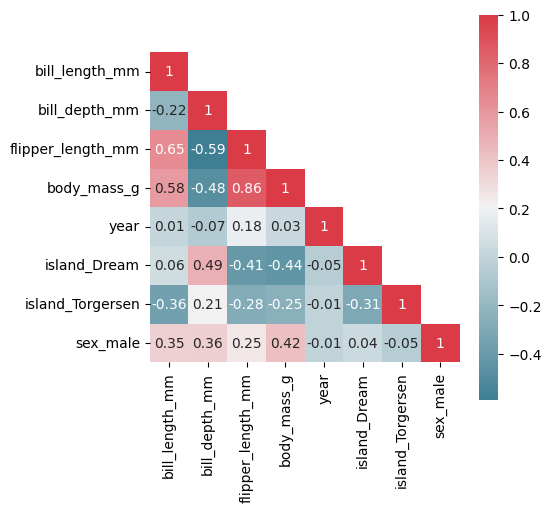

In [10]:
utils.plot_correlation_matrix(X_train)

--------

## Now, what are our possibilities to interpret a Random Forest model?

### Interpretation with Feature Importance Measures

#### Permutation Feature Importance

In the [Tutorial_PermutationFeatureImportance.ipynb](../xai-model-agnostic/Tutorial_PermutationFeatureImportance.ipynb) notebook you were introduced to the model-agnostic Permutation Feature Importance. Recall, the Permutation Feature Importance is defined to be the decrease in a model score when a single feature value is randomly permuted. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. Lets now apply it to our penguins dataset:

<font color='green'>

#### Task 1: Calculate permutation feature impotance for the trained Random Forest model. Therefore, define the appropriate scorer and compute the permutation feature importance scores by filling in the two lines below.


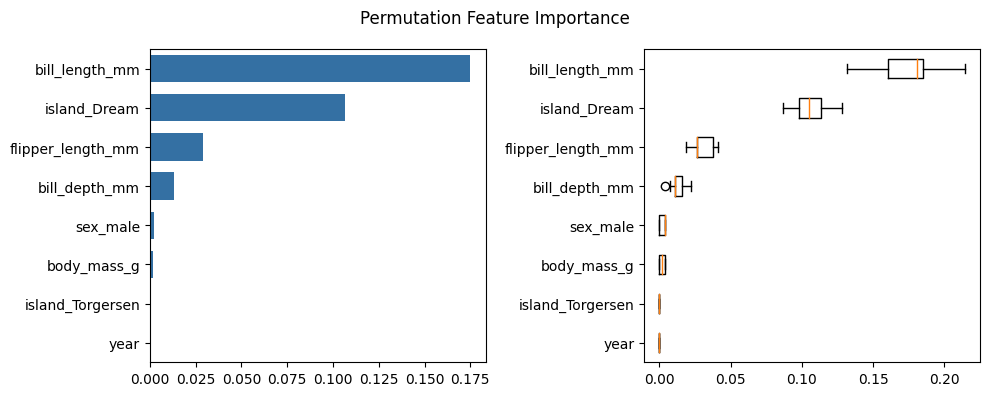

In [11]:
# scorer = ...
scorer = get_scorer("accuracy")
# result = ...
result = permutation_importance(rf, X_train, y_train, n_repeats=20, random_state=seed)
utils.plot_permutation_feature_importance(result=result, data=X_train, title="Permutation Feature Importance")

<font color='green'>

#### Question 1: How big is the influence of the most important feature on the model performance and what does it tell us?

<font color='grey'>

#### Your Answer: 

Permutation of the feature ‘bill_length_mm’ drops the accuracy by at most 0.22 (right plot), and on average 0.17 (left plot). Compared to the overall model performance of 95% accuracy, the most important feature only leads to a rather small decrease in model performance.

#### Random Forest Feature Importance

An alternative to Permutation Feature Importance is the Random Forest specific feature importance method based on the mean decrease in impurity. The mean decrease in impurity is defined as the total decrease in node impurity averaged over all trees of the ensemble. This Feature Importances is directly provided by the fitted attribute `feature_importances_` .

Lets plot the feature importance based on mean decrease in impurity:

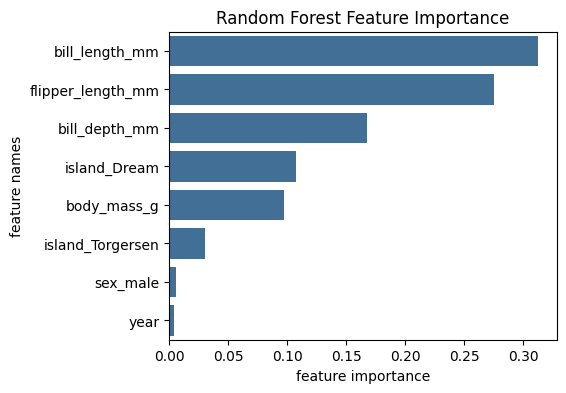

In [12]:
utils.plot_impurity_feature_importance(rf.feature_importances_, names=X_train.columns, title="Random Forest Feature Importance")

<font color='green'>

#### Question 2: Inspect the differences between the results of the two feature importance plots. What do you notice? 
_Hint:_ Take a look at the correlation plot above!

<font color='grey'>

#### Your Answer: 

1. Random Forest Feature Importance identifies more important features than the Permutation Feature Importance.
2. It seems that the feature importance of the correlated features flipper_length and body_mass are artificially lower due to the high correlation. Random Forest Feature Importance does not seem to be affected by this correlation effect. This shows that Permutation Feature Importance results should be interpreted with great care in the presence of correlated features.


### Interpretation with SHAP

In the [Tutorial_SHAP.ipynb](../xai-model-agnostic/Tutorial_SHAP.ipynb) notebook you were introduced to the model-agnostic SHAP method. Recall, with SHAP we get contrastive explanations that compare the prediction with the average prediction. The global interpretations are consistent with the local explanations, since the Shapley values are the “atomic unit” of the global interpretations.

<font color='green'>

#### Task 2: Run SHAP on the trained Random Forest model. Therefore, define the appropriate explainer and calculate the SHAP values by filling in the lines below.

In [13]:
# run SHAP
explainer = shap.TreeExplainer(rf)
# explainer = ...
shap_values = explainer(X_train)
# shap_values = ...

# get original unscaled feature values
scaler = data_and_model[5]
X_train_unscaled = scaler.inverse_transform(X_train)
X_train_unscaled = pd.DataFrame(X_train_unscaled, columns = X_train.columns)
shap_values.data = X_train_unscaled

#NOTE: the new SHAP package is still a bit buggy.
#      the returned dimensions for the shaply value
#      matrix are swapped. Hence, we need to put
#      then into correct order first.
shap_values.values = list(np.transpose(shap_values.values,(2,0,1)))

Remember that the SHAP values explain why a prediction for a single observation is different from the average prediction for all the observations in the data set. For our penguins classifier, the shap explainer produces three expected values, corresponding to the average predicted probability for each class, which is essentially the predicted class frequency in the dataset.

In [14]:
# average prediction for the dataset
ev = explainer.expected_value
print(f'Models average class probability for our data set is: {round(ev[0],2)} for Adelie, {round(ev[1],2)} for Chinstrap and {round(ev[2],2)} for Gentoo.')

Models average class probability for our data set is: 0.44 for Adelie, 0.21 for Chinstrap and 0.35 for Gentoo.


To get a general overview on the features with the highest contributions, we can plot the average absolute SHAP values for each penguin species.

<font color='green'>

#### Task 3: Plot the summary plot as barplot for the absolute SHAP values by filling in the line below.

In [ ]:
shap.summary_plot(
    shap_values.values, 
    shap_values.data, 
    plot_type='bar')
# shap.summary_plot(...)

For a more granular view we can use the beeswarm or violin plots. Remember, those have to be plotted class-wise.

<font color='green'>

#### Task 4: Plot the summary plot as beeswarm plot for the SHAP values by filling in the line below. For multi-class calssification, there have to be plotted per class. (Hint: check out the SHAP Tutorial's extra material for multi-class SHAP analysis.)

In [ ]:
# summary plot for class 0 = Adelie
target_class = 0
shap.summary_plot(
    shap_values.values[target_class], 
    shap_values.data)
# shap.summary_plot(...)

In [ ]:
# summary plot for class 1 = Chinstrap
target_class = 1
shap.summary_plot(
    shap_values.values[target_class], 
    shap_values.data)
# shap.summary_plot(...)

In [ ]:
# summary plot for class 2 = Gentoo
target_class = 2
shap.summary_plot(
    shap_values.values[target_class], 
    shap_values.data)
# shap.summary_plot(...)

<font color='green'>

#### Question 3: What conclusions can you draw from the summary plots above?


<font color='grey'>

#### Your Answer: 

- not all features are equally important for the classification of each species
- for the Adelie species, a low bill and flipper length as well as a high bill depth and not being located on the Dream island increases the class probability
- for the Chrinstrap species, a high bill length and depth as well as being located on the Dream island increases the class probability
- for the Gentoo species, a high flipper length and body mass as well as a small bil depth and not being located on the Dream island increases the class probability

### Interpretation with Forest-Guided Clustering

In the [Tutorial_FGC.ipynb](./Tutorial_FGC.ipynb) notebook you were introduced to the Random Forest specific FGC method. Recall, FGC does not assume independence of model features, because it computes the feature importance based on subgroups of instances that follow similar decision rules within the Random Forest model.

Even though the Random Forest Feature Importance and SHAP do overcome some disadvantages of Permutation Feature Importance and give us some information about class-wise feature contributions, they do not give us further insights into the decision paths of the Random Forest model. Forest-Guided Clustering (FGC) leverages the tree structure of Random Forest models to get insights into the decision making process of the model, which might be able to help us out here... 

<font color='green'>

#### Task 5: Run FGC on the trained Random Forest model. Therefore, define the FgClustering object and run fgc by filling in the lines below.

In [19]:
# create an FGC instance
fgc = FgClustering(model=rf, data=X_train, target_column=y_train)
# fgc = 

# Run the fgc instance
fgc.run()
# fgc. ...

Interpreting RandomForestClassifier


 17%|█▋        | 1/6 [00:00<00:02,  2.09it/s]

For number of cluster 2 the Jaccard Index is 0.8853301722947294
For number of cluster 2 the score is 0.3593212884282253


 33%|███▎      | 2/6 [00:00<00:01,  2.10it/s]

For number of cluster 3 the Jaccard Index is 1.0
For number of cluster 3 the score is 0.0174447873487719


 50%|█████     | 3/6 [00:01<00:01,  1.79it/s]

For number of cluster 4 the Jaccard Index is 0.9982243017146888
For number of cluster 4 the score is 0.026408044397251973


 67%|██████▋   | 4/6 [00:02<00:01,  1.43it/s]

For number of cluster 5 the Jaccard Index is 0.9307077873107285
For number of cluster 5 the score is 0.02112643551780158


 83%|████████▎ | 5/6 [00:03<00:00,  1.15it/s]

For number of cluster 6 the Jaccard Index is 0.6426387671697052
For number of cluster 6 the score is 0.020544263012948576


100%|██████████| 6/6 [00:05<00:00,  1.16it/s]

For number of cluster 7 the Jaccard Index is 0.6188298656478285
For number of cluster 7 the score is 0.017609368296813064
Optimal number of cluster is: 3


When training the model, we encoded some features and standardized the feature values beforehand. However, in the visualizations it would be nice to show the original features, which is possible with FGC. Therefore, we decode and back-transform the features to the original space and then re-calculate the cluster-wise statistics.

In [20]:
# get original unscaled feature values
scaler = data_and_model[5]
X_train_original = scaler.inverse_transform(X_train)
X_train_original = pd.DataFrame(X_train_original, columns = X_train.columns)

# covert dummy encoded features back to category and recalculate p-value statistics
dummies_island = pd.DataFrame({"Torgersen": X_train_original['island_Torgersen'], "Dream": X_train_original['island_Dream'], "Biscoe": pd.Series(X_train_original['island_Dream'] + X_train_original['island_Torgersen']).replace({0:1, 1:0})})
X_train_original['island'] = pd.Series(dummies_island.columns[np.where(dummies_island!=0)[1]]).astype('category')

dummies_sex = pd.DataFrame({"male": X_train_original['sex_male'], "female": X_train_original['sex_male'].replace({0:1, 1:0})})
X_train_original['sex'] = pd.Series(dummies_sex.columns[np.where(dummies_sex!=0)[1]]).astype('category')

X_train_original = X_train_original.drop(columns=["island_Torgersen", "island_Dream", "sex_male"])

fgc.calculate_statistics(data=X_train_original, target_column=y_train)

Lets now plot the global and local FGC feature importance.

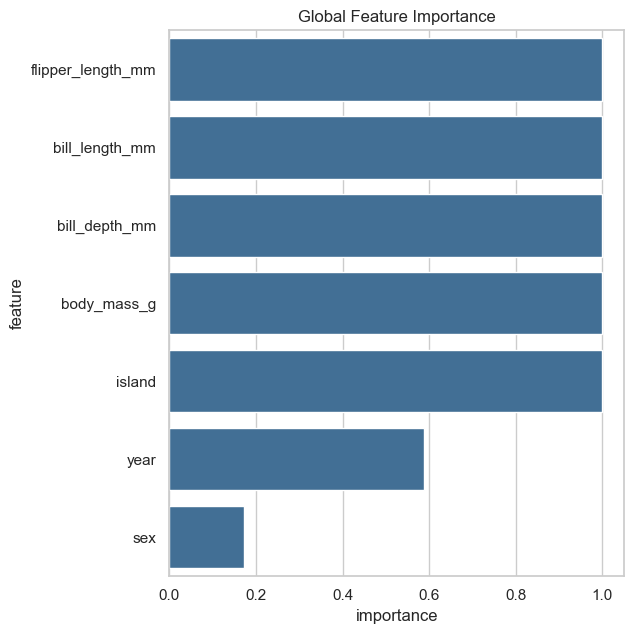

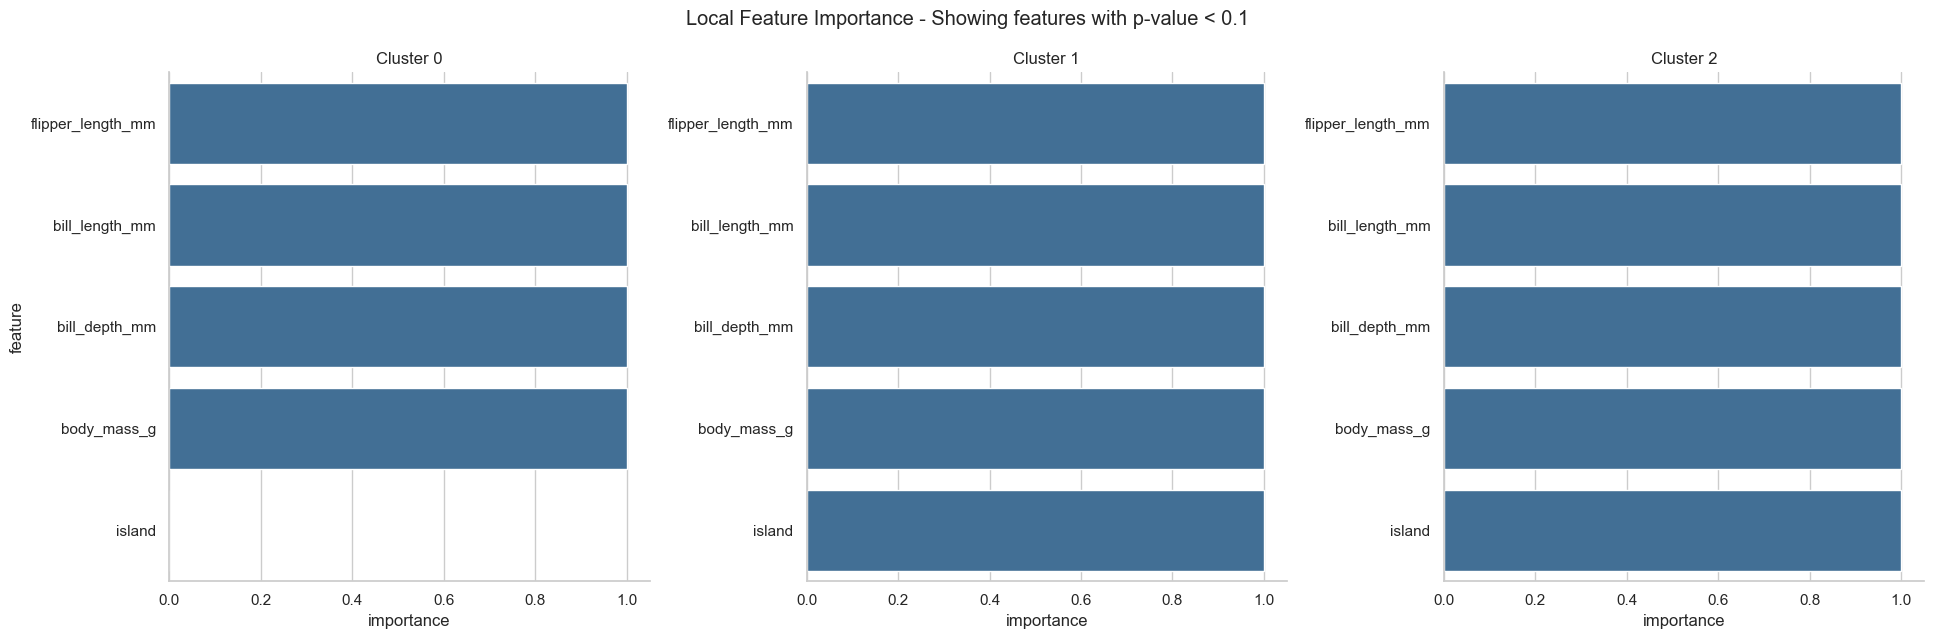

In [21]:
%matplotlib inline
# Plot global feature importance
fgc.plot_global_feature_importance()
fgc.plot_local_feature_importance(thr_pvalue=0.1) # Set thr_pvalue=1 to show all the features

One of the major advantages of FGC is the visualization of the Random Forest decision path, which can help us to understand the decision making process of our model.

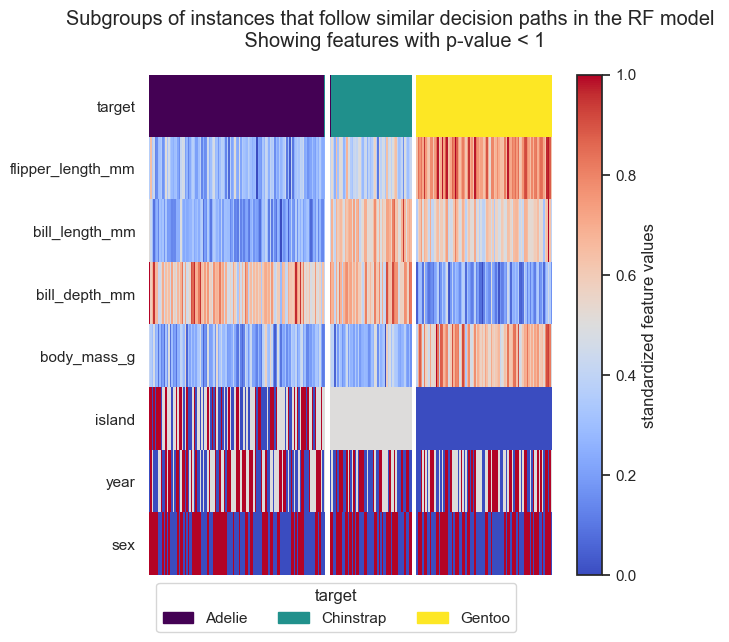

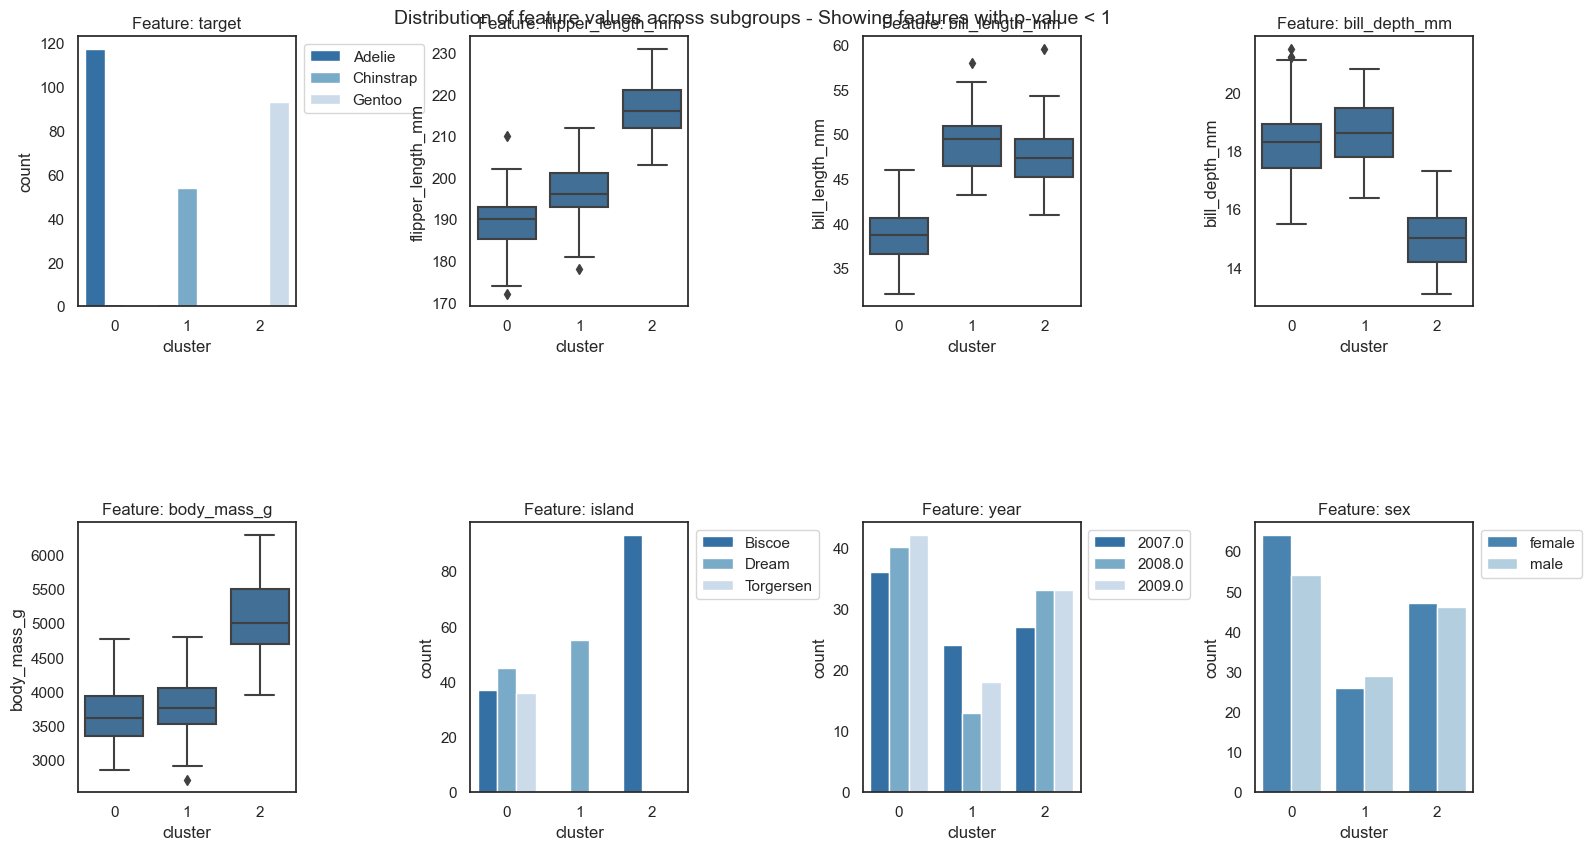

In [22]:
fgc.plot_decision_paths(thr_pvalue=1, num_cols = 4)

<font color='green'>

#### Question 4: What do you observe when comparing the Permutation Feature Importance, Random Forest Feature Importance, SHAP Bar Plot and the FGC Feature Importance?


<font color='grey'>

#### Your Answer: 

SHAP, FGC and RF feature importance largely agree wrt feature importances while Permutation Feature Importance shows some major differences to the other methods.

<font color='green'>

#### Question 5: What do you observe when comparing the SHAP Beeswarm Plots and the FGC Decision Path Plot?


<font color='grey'>

#### Your Answer: 

One of the major differences is that SHAP only provides constrative explanation, i.e. what explains the deviation from the baseline, while FGC allows us to actually visualize patterns in the data, independent of the features overall predictive power and in particular wrt. correlated features. Furthermore, we have the possibility to display the features in their original feature space which makes the interpretation much easier and human readable. We can see that features like the dream island have a high SHAP contribution for the Adelie species prediction although, looking at the FGC decision path plot, the island feature has no discriminative power between Adelie and Chinstrap / Gentoo species. In addition, the Torgersen island has almost no contribution to the Adelie prediction however, only Adelie but no Gento or Chinstrap penguins are found on that island. FGC allows us to clearly specify what attributes define the different penguin species, while SHAP values only tell us which features contribute to a prediction that deviates from the baseline.

<font color='green'>

#### Question 6: Try to describe each species (Adelie = 0, Chinstrap = 1, Gentoo = 2). Use the following examples to guide you:

- What makes Gentoo different from the other two species? 
- What makes Chinstrap different from Adelie?
- ...

<center><img src="https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/dataset_penguins_billlength.png?raw=true" width="200" /></center>

<font color='grey'>

#### Your Answer: 

Some possible answers are:

- Gento has a larger body mass and smaller bill depth
- Adelie has smaller bill length